In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
import tensorflow_probability as tfp
tfd = tfp.distributions
num_iter = 1000

In [3]:
# TEST & DEBUG CELL
# Data Generation
m = 1000
x_data = np.linspace(5.5, -5.5, m)
r_data = np.random.randn(m)           # Noise

y_data = 8*np.sin(0.75*x_data) + 2*x_data + r_data
x_data = x_data.astype("float32")
x_data = x_data.reshape(x_data.size,1)
y_data = y_data.astype("float32")
y_data = y_data.reshape(y_data.size,1)

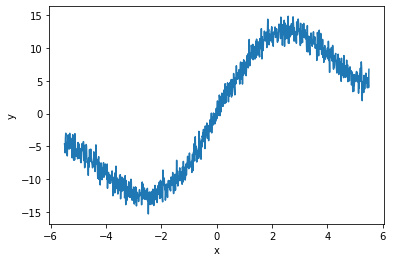

In [4]:
# Visualize train data

plt.plot(x_data, y_data)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

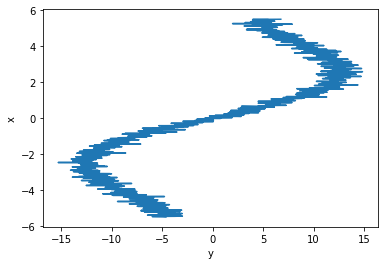

In [5]:
# Visualize the mapping to be learned

plt.plot(y_data, x_data)
plt.ylabel('x')
plt.xlabel('y')
plt.show()

In [6]:
# Defining MDN network layers & params

hidden_units = 20
k_mixt = 3
hidden_dense = Dense(hidden_units, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(0.01))
hidden = hidden_dense(y_data)

alpha_dense = Dense(k_mixt, activation=tf.nn.softmax)
alpha = alpha_dense(hidden)

mu_dense = Dense(k_mixt, activation=None)
mu = mu_dense(hidden)

sigma_dense = Dense(k_mixt, activation = tf.nn.softplus, name='sigma')
sigma = sigma_dense(hidden)

gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),components_distribution=tfd.Normal(loc=mu, scale=sigma))
tvars = hidden_dense.trainable_variables + alpha_dense.trainable_variables + mu_dense.trainable_variables+sigma_dense.trainable_variables
optimizer = tf.keras.optimizers.Adam()
def step():
  with tf.GradientTape() as tape:
    hidden = hidden_dense(y_data)
    alpha = alpha_dense(hidden)
    mu = mu_dense((hidden))
    sigma=sigma_dense(hidden)
    gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),components_distribution=tfd.Normal(loc=mu, scale=sigma))
    loss = -tf.reduce_sum(gm.log_prob(tf.reshape(x_data,(-1,))))
    grads = tape.gradient(loss,tvars)
  (grads, _) = tf.clip_by_global_norm(grads, clip_norm=1.0)
  optimizer.apply_gradients(
    zip(grads, tvars)) 
  return loss

In [8]:
# Train network for given number of iterations

for i in range(1, num_iter+1, 1):
  step()
  if i%100 == 0:
    print('Iterations completed - ', i)

Iterations completed -  100
Iterations completed -  200
Iterations completed -  300
Iterations completed -  400
Iterations completed -  500
Iterations completed -  600
Iterations completed -  700
Iterations completed -  800
Iterations completed -  900
Iterations completed -  1000


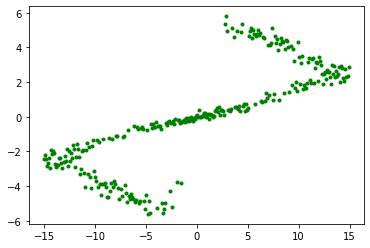

In [9]:
# Visualize Learned mapping

x_test = np.float32(np.arange(-15,15,0.1))
test_eg = x_test.size
x_test = x_test.reshape(test_eg,1)
def predict(y_data):
  hidden = hidden_dense(y_data)
  alpha = alpha_dense(hidden)
  mu = mu_dense((hidden))
  sigma=sigma_dense(hidden)
  gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),components_distribution=tfd.Normal(loc=mu, scale=sigma))
  return gm.sample()
sample = predict(x_test)
plt.plot(x_test, sample, 'g.')